In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math
from functools import partial
from tqdm import tqdm

import bases
import eigensolvers
import generators
import otrhogonalizations
import representations
import reconstructions
import utils

In [2]:
def show_reconstruction_matrix(df, vmin=0, vmax=None, title='Title'):
    fig, ax = plt.subplots(figsize=(16,12))
    ax.set_title(title)
    sns.heatmap(df, vmin=vmin, vmax=vmax, linewidth=0.5, ax=ax, annot=True, fmt='.2f')
    plt.show()
    return

def get_settings(ndim=1, num_col=1500, degree=7, combination=True):
    if ndim == 2:
        initial_state = (0, 0)
        Yr, Xr = utils.generate_krylov(generators.two_torus_evolution_function, generators.two_torus_observable_func, initial_state, num_col)
        utils.plot_torus(Yr)
    else:
        initial_state=0
        Yr, Xr = utils.generate_krylov(generators.angle_evolution, generators.unit_circle_observable_function, initial_state, num_col)
        utils.plot_complex_on_unit_circle(Yr)
    basis = partial(bases.fourier_basis, degree=degree, combinations=combination)
    return Xr, basis

def test_eigenfunction_power(Ur, representation_func, basis):
    n_dim = Ur.shape[1]
    K, V, L = representation_func(Ur, basis=basis)
    eigenvalues, true_V, n = eigensolvers.QR_algorithm_with_inverse_iteration(K)
    V /= np.linalg.norm(V, axis=1)
    eigenvalue_angles = np.angle(eigenvalues)
    eigenvalue_matrix = np.array([[e1/e2 if abs(e2)>0.01 else e1 for e2 in eigenvalue_angles] for e1 in eigenvalue_angles])
    eigenvalue_matrix_df = pd.DataFrame(eigenvalue_matrix, columns=eigenvalue_angles, index=eigenvalue_angles)

    N, M = eigenvalue_matrix.shape
    power_vector_matrix = []
    eigenvector_norms = []
    schur_power_vector_matrix = []
    schur_eigenvector_norms = []
    # power_vector_matrix_pi = []
    # power_vector_matrix_3pi = []
    # pv_angle_matrix = []
    for j in tqdm(range(M)):
        power_vector_matrix.append([])
        eigenvector_norms.append([])
        schur_power_vector_matrix.append([])
        schur_eigenvector_norms.append([])
        # pv_angle_matrix.append([])
        # power_vector_matrix_pi.append([])
        # power_vector_matrix_3pi.append([])
        for i in range(N):
            p = eigenvalue_angles[i]/eigenvalue_angles[j] if abs(eigenvalue_angles[j]) > 1e-3 else eigenvalue_angles[i] / (eigenvalue_angles[j] + 2*np.pi)
            pv = otrhogonalizations.powered_vector(true_V[:,j], basis, p, n_dim)
            pv /= np.linalg.norm(pv)
            alpha = np.inner(true_V[:,i], pv.conj()).item()
            power_vector_matrix[j].append(alpha)
            eigenvector_norms[j].append(np.inner(true_V[:,i], true_V[:,j].conj()).item())

            schur_pv = otrhogonalizations.powered_vector(V[:,j], basis, p, n_dim)
            # schur_pv /= np.linalg.norm(schur_pv)
            schur_alpha = np.inner(V[:,i], schur_pv.conj()).item()
            schur_power_vector_matrix[j].append(schur_alpha)
            schur_eigenvector_norms[j].append(np.inner(V[:,i], V[:,j].conj()).item())
            # pv_angle_matrix[j].append(np.angle(ip))
            # power_vector_matrix_pi[j].append(abs(np.inner(true_V[:,j], 1j*pv.conj()).item()))
            # power_vector_matrix_3pi[j].append(abs(np.inner(true_V[:,j], -1j*pv.conj()).item()))

    power_vector_matrix = np.array(power_vector_matrix)
    eigenvector_norms = np.array(eigenvector_norms)
    schur_power_vector_matrix = np.array(schur_power_vector_matrix)
    schur_eigenvector_norms = np.array(schur_eigenvector_norms)
    # power_vector_matrix_pi = np.array(power_vector_matrix_pi)
    # power_vector_matrix_3pi = np.array(power_vector_matrix_3pi)
    # pv_angle_matrix = np.array(pv_angle_matrix)

    power_vector_matrix_df = pd.DataFrame(power_vector_matrix, columns=eigenvalue_angles, index=eigenvalue_angles)
    eigenvector_norms_df = pd.DataFrame(eigenvector_norms, columns=eigenvalue_angles, index=eigenvalue_angles)
    schur_power_vector_matrix_df = pd.DataFrame(schur_power_vector_matrix, columns=eigenvalue_angles, index=eigenvalue_angles)
    schur_eigenvector_norms_df = pd.DataFrame(schur_eigenvector_norms, columns=eigenvalue_angles, index=eigenvalue_angles)
    # power_vector_matrix_pi_df = pd.DataFrame(power_vector_matrix_pi, columns=eigenvalues, index=eigenvalues)
    # power_vector_matrix_3pi_df = pd.DataFrame(power_vector_matrix_3pi, columns=eigenvalues, index=eigenvalues)

    # pv_angle_matrix_df = pd.DataFrame(pv_angle_matrix, columns=eigenvalues, index=eigenvalues)

    return eigenvalue_matrix_df, power_vector_matrix_df, eigenvector_norms_df, schur_power_vector_matrix_df, schur_eigenvector_norms_df

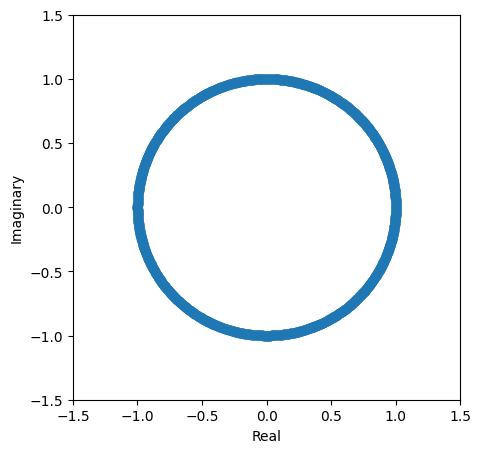

(1500, 1)

In [3]:
Xr, basis  = get_settings()
Xr.shape

In [4]:
eigenvalue_matrix_df, power_vector_matrix_df, eigenvector_norms_df, schur_power_vector_matrix_df, schur_eigenvector_norms_df = test_eigenfunction_power(Xr, representations.mpEDMD_matrix_representation, basis)

100%|██████████| 15/15 [00:20<00:00,  1.34s/it]


# Power (p-value)

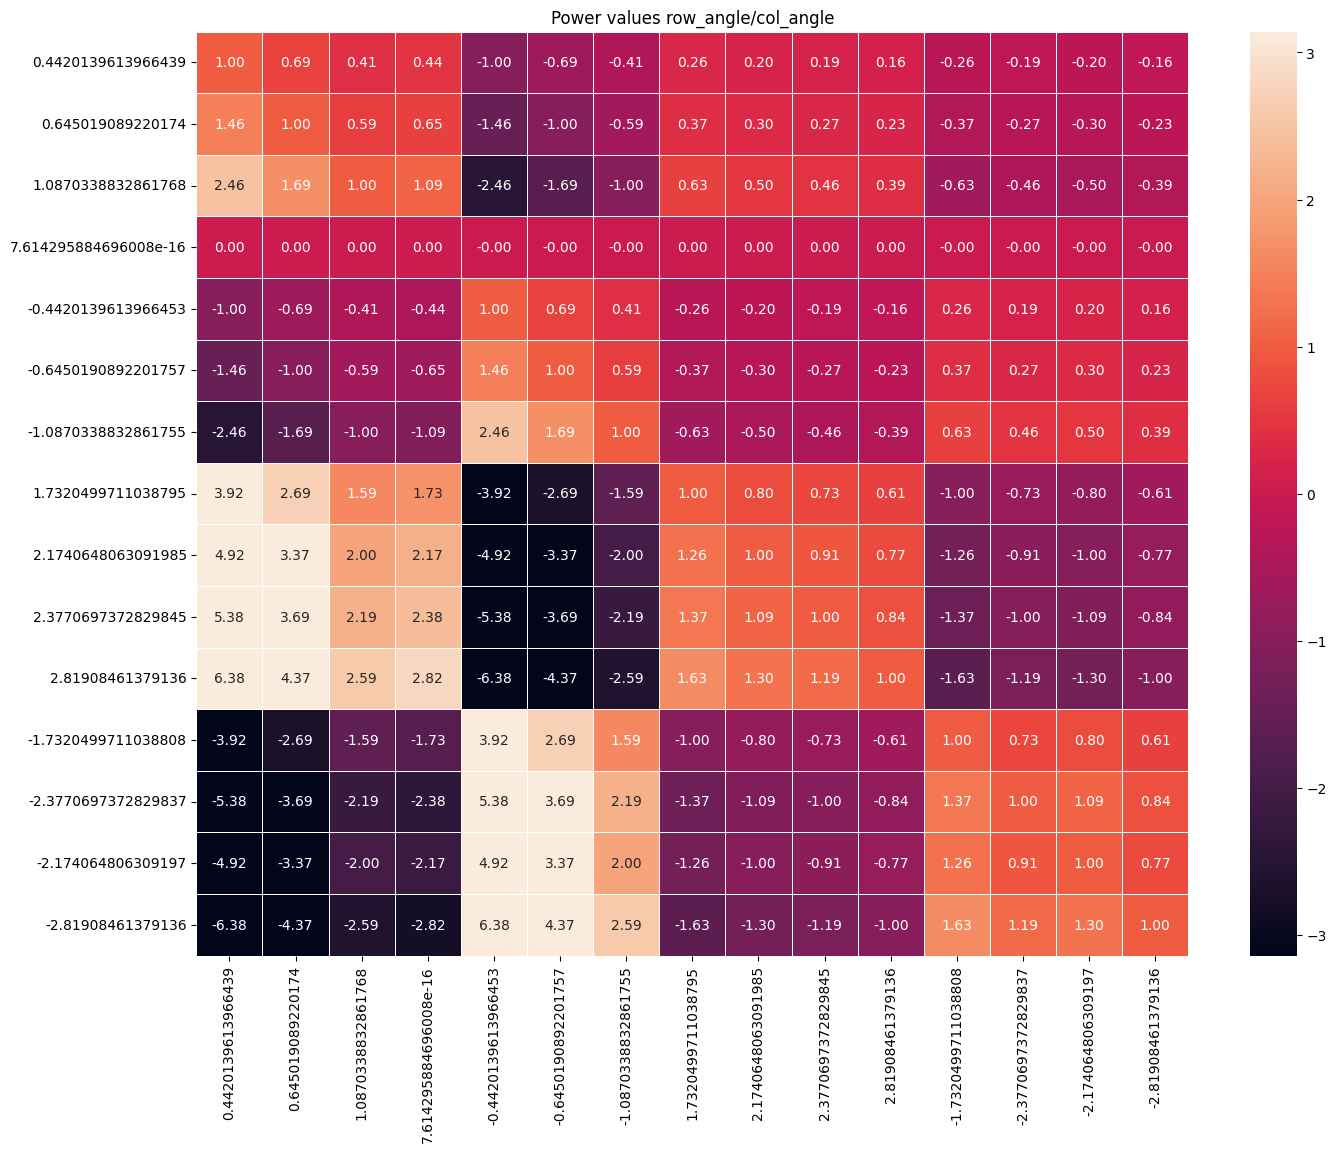

In [5]:
show_reconstruction_matrix(eigenvalue_matrix_df, vmin=-np.pi, vmax=np.pi, title='Power values row_angle/col_angle')

# Absolute value of $\alpha$

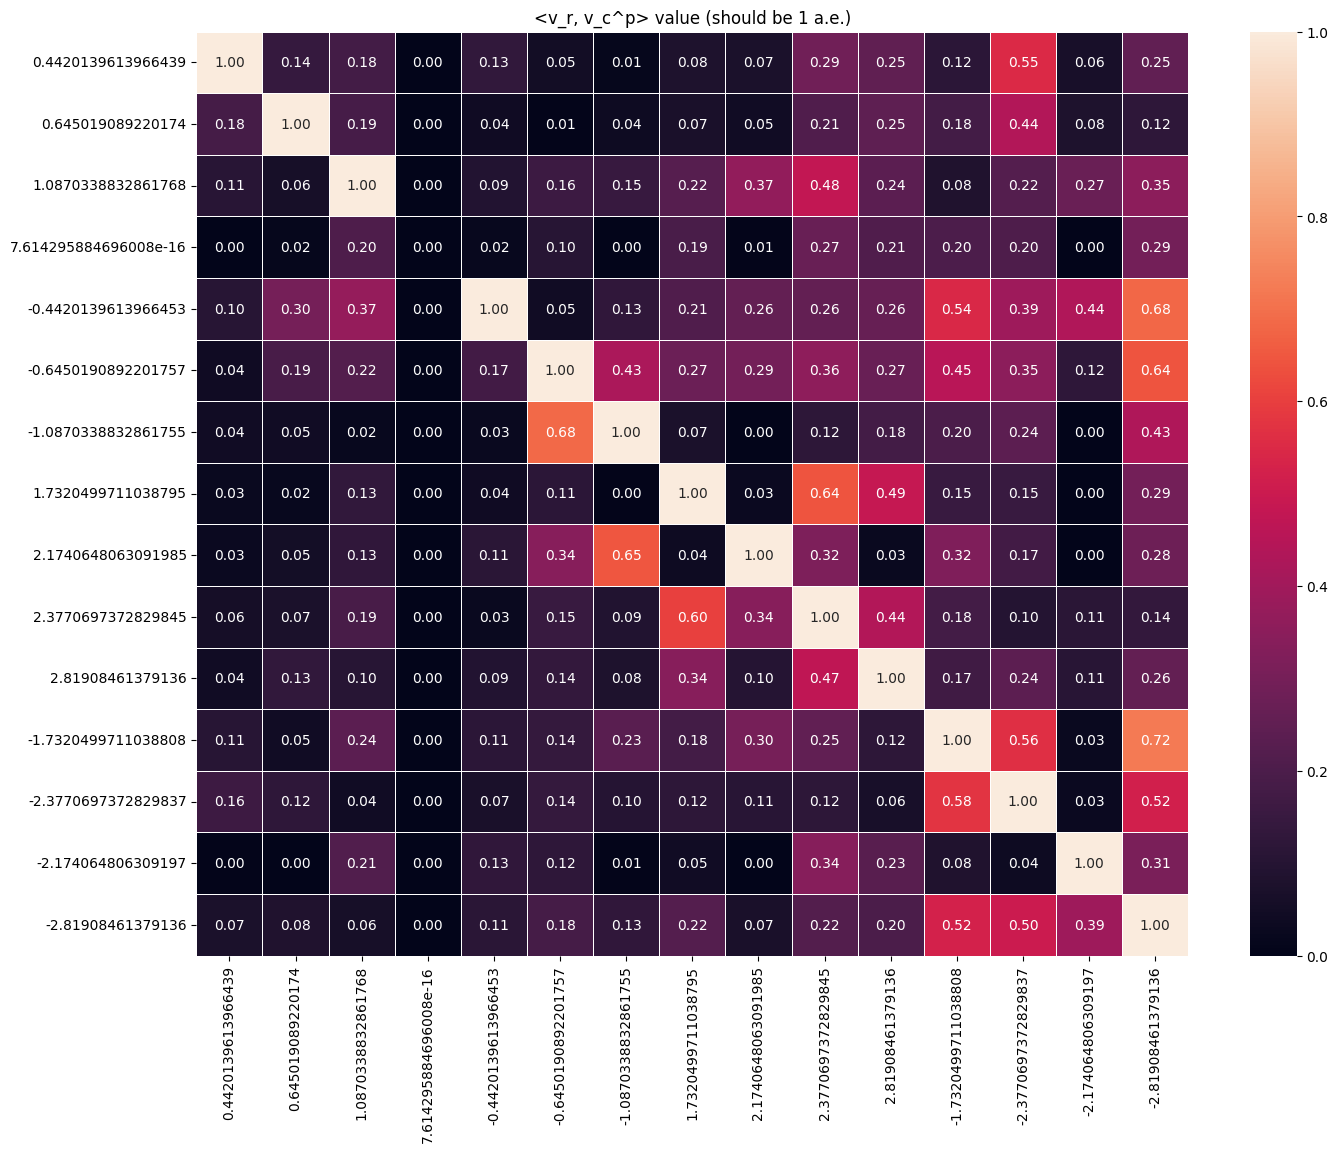

In [6]:
show_reconstruction_matrix(abs(power_vector_matrix_df), vmax=1, title='<v_r, v_c^p> value (should be 1 a.e.)')

# Absolute value of $\alpha$ angle

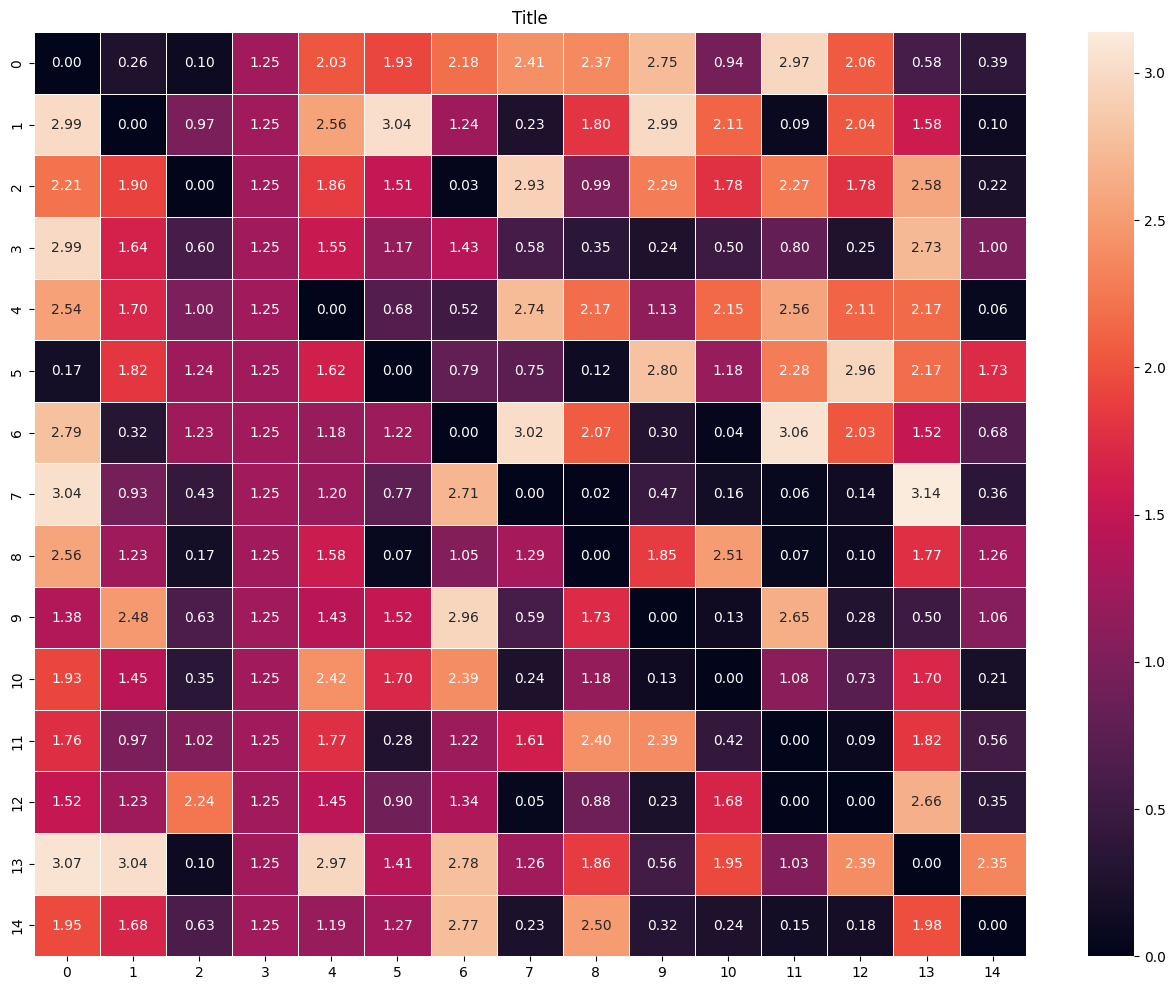

In [7]:
show_reconstruction_matrix(abs(np.angle(power_vector_matrix_df)))

# Inner product between two eigenvectors

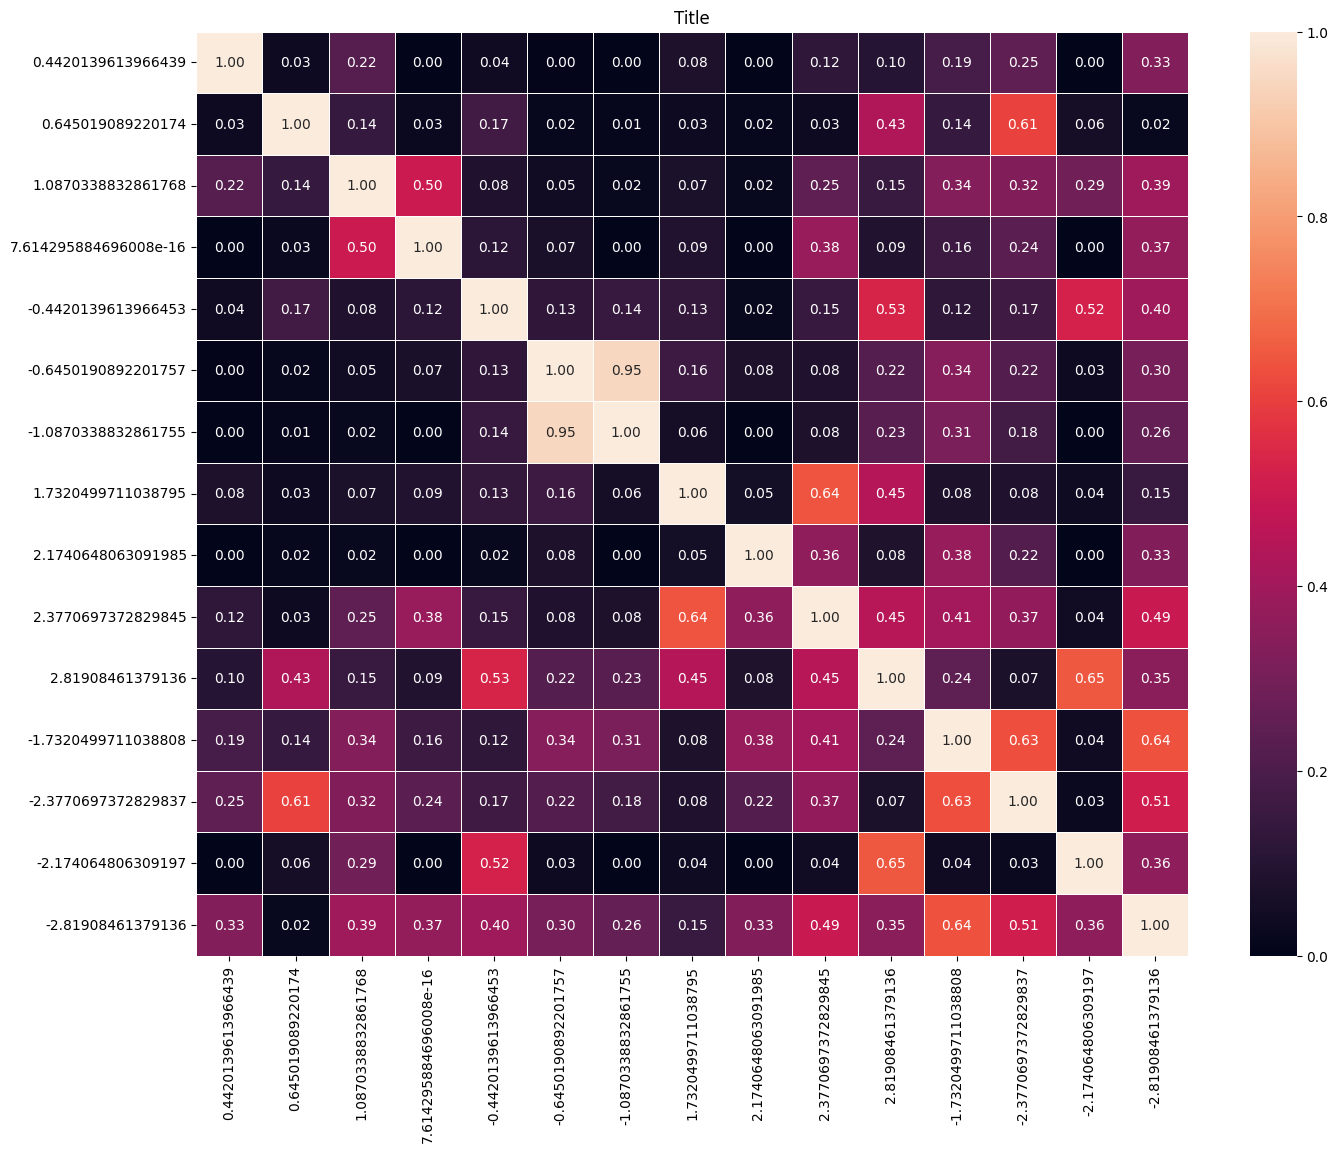

In [8]:
show_reconstruction_matrix(abs(eigenvector_norms_df))

In [9]:
# show_reconstruction_matrix(abs(pv_angle_matrix_df.to_numpy()))

In [10]:
# show_reconstruction_matrix(power_vector_matrix_dfs[2].to_numpy(), vmax=1)

# $\lvert \alpha \rvert$ with Schur decomposition

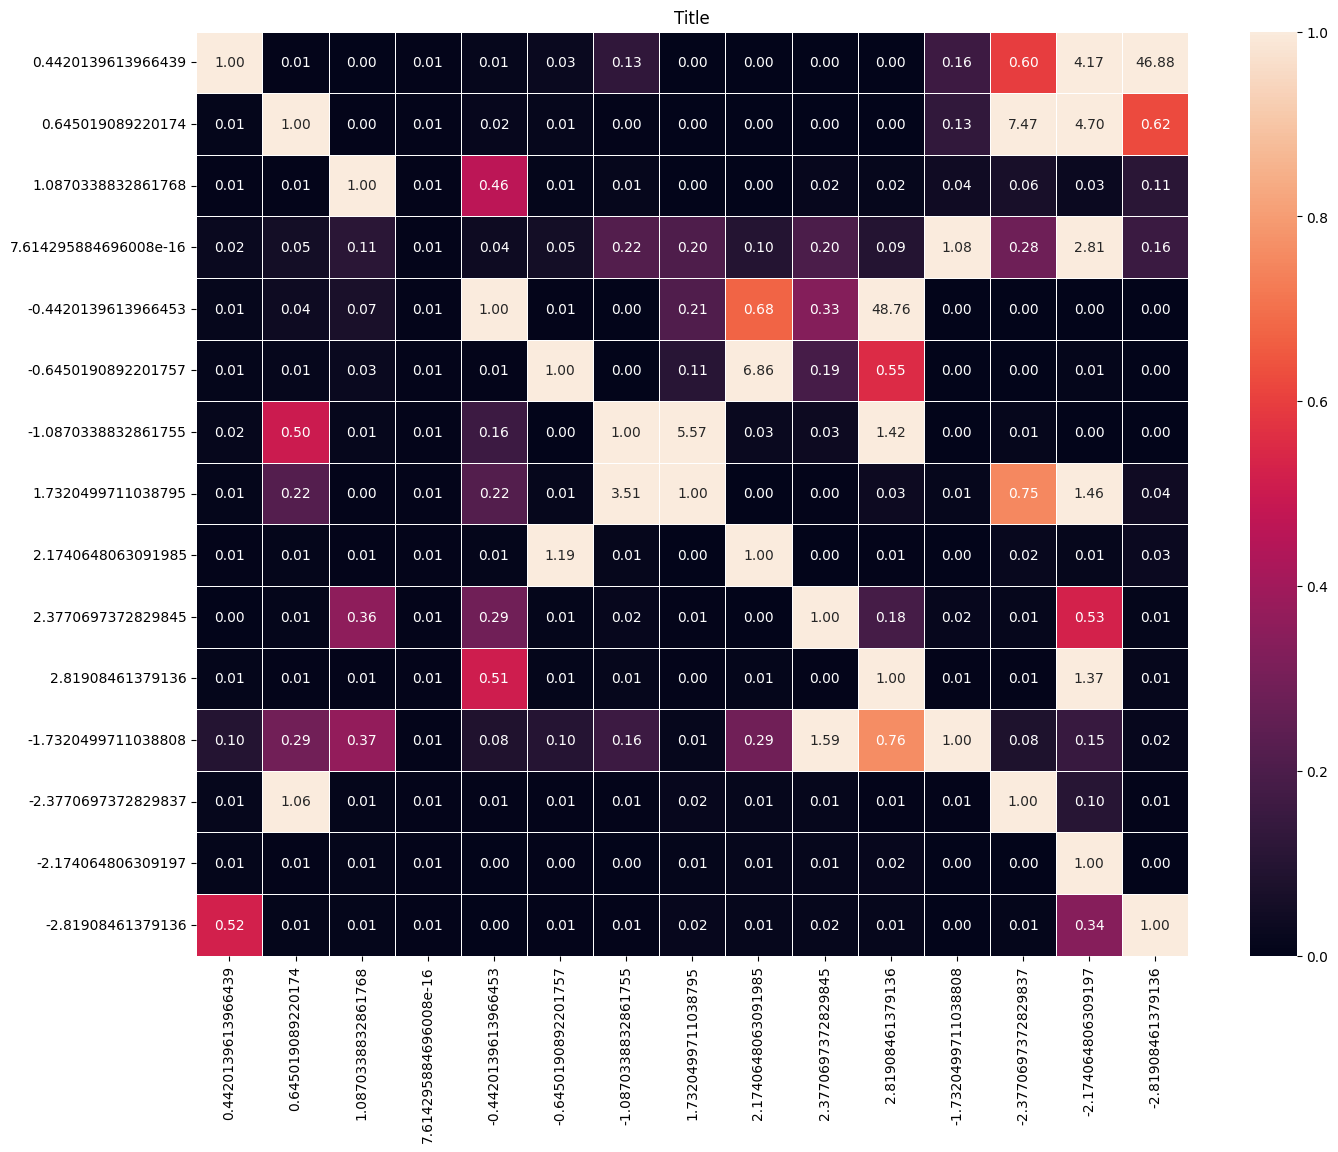

In [11]:
show_reconstruction_matrix(abs(schur_power_vector_matrix_df), vmax=1)

# $\lvert angle(\alpha) \rvert$ with Schur decomposition

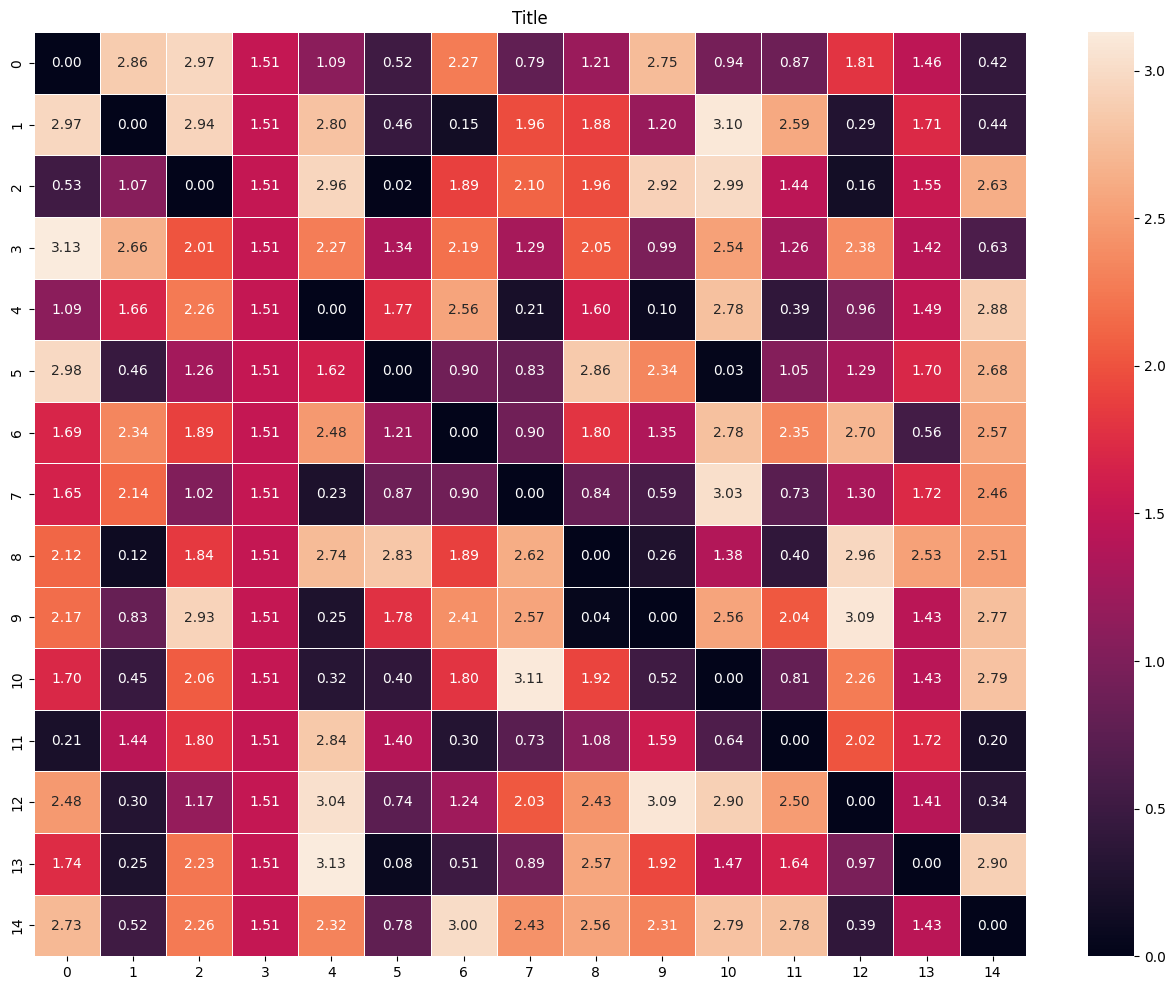

In [12]:
show_reconstruction_matrix(abs(np.angle(schur_power_vector_matrix_df)))

# Inner products with Schur decomposition

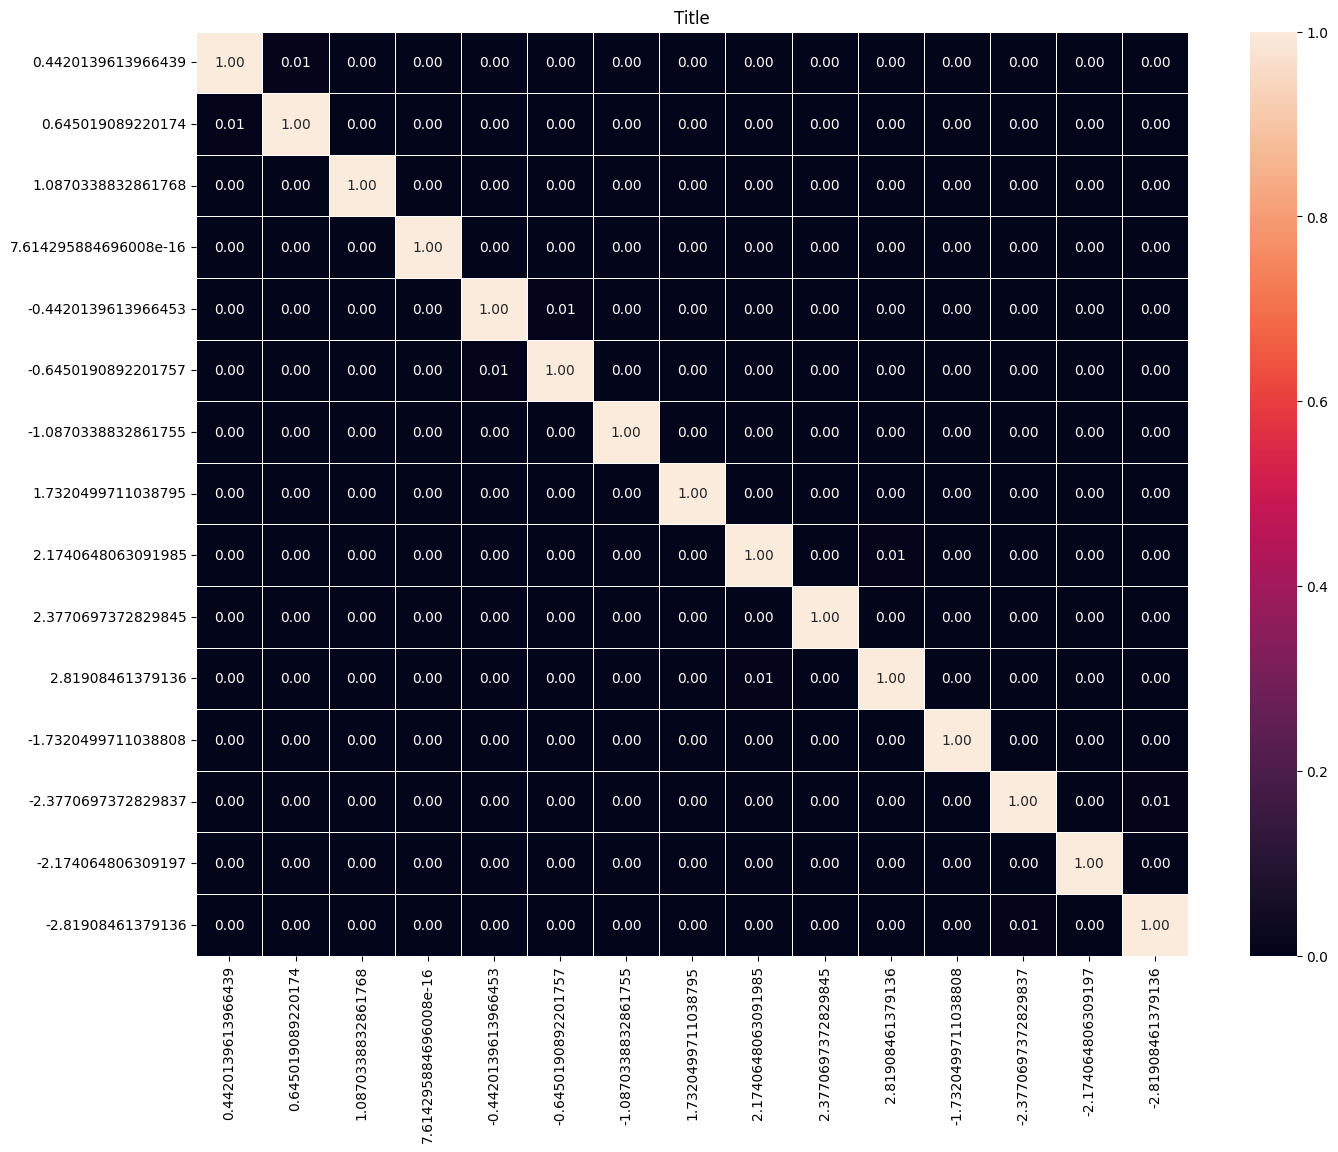

In [13]:
show_reconstruction_matrix(abs(schur_eigenvector_norms_df))